In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import prepare

In [2]:
#pd.set_option('display.max_rows', 111753)

# Data Acquisition

In [54]:
df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
1,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
2,A689724,*Donatello,10/18/2014 06:52:00 PM,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
3,A680969,*Zeus,08/05/2014 04:59:00 PM,08/05/2014 04:59:00 PM,06/03/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Orange Tabby
4,A684617,NaN,07/27/2014 09:00:00 AM,07/27/2014 09:00:00 AM,07/26/2012,Transfer,SCRP,Cat,Intact Female,2 years,Domestic Shorthair Mix,Black


In [46]:
# peek at the df dimension
df.shape

(111753, 12)

In [55]:
# list missing value by col
# need to decide what to do
prepare.report_col_with_null_df(df)

,0,1,2,3,4
0,Name,Outcome Type,Outcome Subtype,Sex upon Outcome,Age upon Outcome
0,35244,8,60878,4,36


In [48]:
pd.DataFrame(df.apply(lambda x: round(sum(x.isnull()/len(df)),2))).T

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,0.0,0.32,0.0,0.0,0.0,0.0,0.54,0.0,0.0,0.0,0.0,0.0


# Conludsion for Initial observation
- Overall, seems like this dataset is relatively complete
- Name & Outcome Subtypes, missin a large portion of data
>
- Initial run, might just completely ignore name and outcome subtype, but I have an hypothesis that name might have a bit of inflence on outcome.  For example if a more human like name (Jackie?) versus something not so human (Spotty?), could it be a factor for adoption outcome?
- or if there's a difference between having name or no name?
>
- Before jumping to the conclusion and completely remove the column - Outcome Subtype, want to double check how does it differ from Outcome Type.

In [7]:
# notes:

# all columns are object types
# MonthYear seemed to be same with DateTime, may drop the col
# animal type maybe just parse dog and cat into 2 df and drop the other species for this analysis

# Derive age from DOB may be more useful?
# age upon outcome might be used instead of calculating age from DOB
# DOB/ age, age upon outcome, sex, breed, color might be the most valuable for prediction
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111753 entries, 0 to 111752
Data columns (total 12 columns):
Animal ID           111753 non-null object
Name                76509 non-null object
DateTime            111753 non-null object
MonthYear           111753 non-null object
Date of Birth       111753 non-null object
Outcome Type        111745 non-null object
Outcome Subtype     50875 non-null object
Animal Type         111753 non-null object
Sex upon Outcome    111749 non-null object
Age upon Outcome    111717 non-null object
Breed               111753 non-null object
Color               111753 non-null object
dtypes: object(12)
memory usage: 10.2+ MB


In [49]:
# double check if DateTime & MonthYear columns are identical
# Yes, so we can safely remove MonthYear
(df["DateTime"] == df["MonthYear"]).mean()

1.0

In [9]:
# compare information in the 2 columns, outcome type and outcome subtype 
# seems like for the first iteration, we can safely remove outcome subtype
# for one it does miss a good portion of data
# for second, the information doesn't seem particularly helpful

print(f"""
What does 'Outcome Type' column tell us?

{df['Outcome Type'].unique()}
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

{df['Outcome Subtype'].unique()}
""")


What does 'Outcome Type' column tell us?

['Adoption' 'Transfer' 'Return to Owner' 'Euthanasia' 'Rto-Adopt' 'Died'
 'Disposal' 'Missing' 'Relocate' nan]
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

[nan 'Partner' 'SCRP' 'Underage' 'Suffering' 'Rabies Risk' 'Offsite' 'Snr'
 'Foster' 'Aggressive' 'Medical' 'In Kennel' 'Enroute' 'In Foster'
 'Behavior' 'Possible Theft' 'At Vet' 'In Surgery' 'Field'
 'Court/Investigation' 'Barn' 'Prc' 'Customer S']



**Decision for handling missing data**
- Name: keep for exploration, does name cause any difference?

- Outcome Type: **dropna** we can afford dropping the 8 missing value

- Outcome Subtype: seems like we can temperarily just **drop column**

- Sex upon outcome: **dropna** we can afford dropping the 4 missing value
> **feature engineer** extract only sex, and drop the other parts in the col

- Age upon outcome: **dropna feature engineer** convert into year/int

In [56]:
# this subsetting contain all info in 'Name' 
# so we could explore the relationship between name and adoption within same species

cat = df[df['Animal Type'] == 'Cat']
dog = df[df['Animal Type'] == 'Dog']

In [57]:
# drop unnecessary columns or columns with too many missing value

df.drop(columns = ['Outcome Subtype', 'Animal ID', 'MonthYear', 'Date of Birth'], inplace = True)

In [61]:
# drop the missing values
# df.dropna(inplace = True)
df.dropna(subset=['Outcome Type', 'Sex upon Outcome','Age upon Outcome'], inplace = True)

In [64]:
# rename the columns for easier typing

df.rename(columns = ({'DateTime':'date_time', 
                      'Outcome Type':'outcome', 
                      'Animal Type': 'species', 
                      'Sex upon Outcome': 'sex',
                      'Age upon Outcome': 'age_destiny', 
                      'Breed': 'breed', 
                      'Color': 'color',
                      'Name': 'name'}), inplace = True)

<Figure size 1440x360 with 0 Axes>

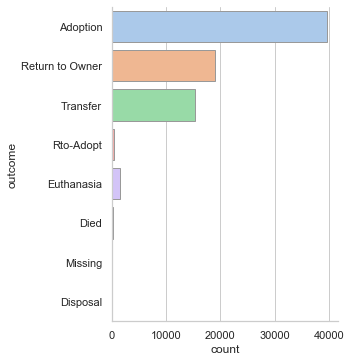

In [14]:
# peek the animal counts in different outcome
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

**Begin feature engineering**

1. Sex upon Outcome	
> extract only sex, and drop the other parts in the col

2. Age upon Outcome
> convert into year/int

In [15]:
# take a look at the different data formats
# easy enough, just mask the raws containing 'Male' or 'Female' 
# reassign as only the sex perspectively to the original col
df.sex.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown'], dtype=object)

In [16]:
df.outcome.unique()

array(['Adoption', 'Return to Owner', 'Transfer', 'Rto-Adopt',
       'Euthanasia', 'Died', 'Missing', 'Disposal'], dtype=object)

<Figure size 2880x2880 with 0 Axes>

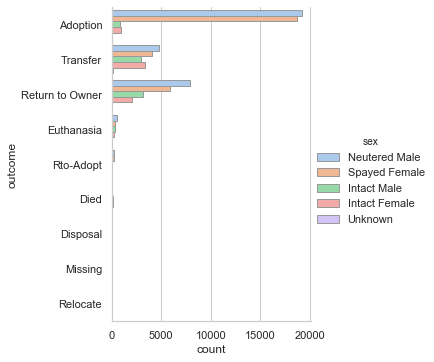

In [17]:
# explore if there's a difference between neutered/ intact
plt.figure(figsize=(40,40))
sns.catplot(y="outcome", hue="sex", kind="count",
            palette="pastel", edgecolor=".6",
            data=df,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

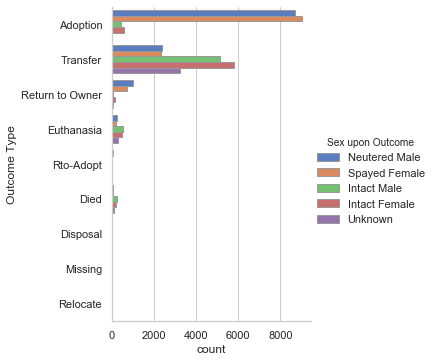

In [18]:
# cat-only: explore if there's a difference between neutered/ spayed & intact 

# Adopted ones, neutered/spayed definitely much more than intact
# higher % of intact cats get transfered
# WHAT DOES TRANSFER REALLY MEANS???

# Look at underlying info: intact vs non-intact

# compared with dogs, there's is a higher proportion of cats get transfered
# dogs shows higher return to owner rate
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="muted", edgecolor=".6",
            data=cat,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

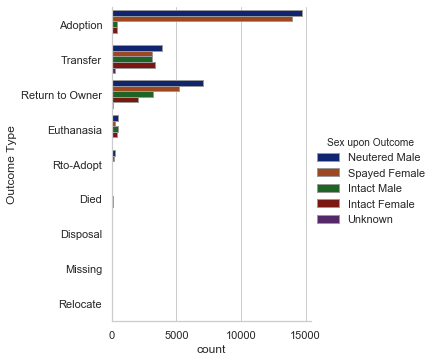

In [19]:
# dog-only: explore if there's a difference between neutered/ spayed & intact
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="dark", edgecolor=".6",
            data=dog,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

In [65]:
df['sex_transformed'] = df.sex
df.loc[df.sex_transformed.str.contains('Male'), 'sex_transformed'] = 'Male'
df.loc[df.sex_transformed.str.contains('Female'),'sex_transformed'] = 'Female'

In [21]:
# handle Age upon Outcome
# use "day" as unit for all results

In [66]:
# split the numbers and units into 2 columns for unit conversion
df['age_number'], df['age_unit'] = zip(*df.age_destiny.str.split(' '))

In [67]:
# convert data type for downstream calculation
df.age_number = df.age_number.astype(int)

In [68]:
x = df.age_unit
# set conditions
# strings contain week, month, year need conversion
# strings contain day remain the same
condlist = ([
    x.str.contains('week'),
    x.str.contains('month'),
    x.str.contains('year'),
    x.str.contains('day')
            ])
# when meeting the quiteria, do these math
choicelist = (df.age_number * 7,
              df.age_number * 30.5, 
              df.age_number * 365,
              df.age_number)
# store info back into df after conversion
df['age_transformed'] = np.select(condlist, choicelist)

In [69]:
# take a look at df, now we need to drop some columns again
df.head(5)

,name,date_time,outcome,species,sex,age_destiny,breed,color,sex_transformed,age_number,age_unit,age_transformed
0,Moose,02/13/2016 05:59:00 PM,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,Male,4,months,122.0
1,NaN,03/18/2014 11:47:00 AM,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Male,6,days,6.0
2,*Donatello,10/18/2014 06:52:00 PM,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,Male,2,months,61.0
3,*Zeus,08/05/2014 04:59:00 PM,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Orange Tabby,Male,2,months,61.0
4,NaN,07/27/2014 09:00:00 AM,Transfer,Cat,Intact Female,2 years,Domestic Shorthair Mix,Black,Female,2,years,730.0


In [70]:
df.drop(columns = ['age_number', 'age_unit'], inplace = True)

In [71]:
df = df[['date_time', 'name', 'outcome', 'species', 'sex','sex_transformed', 'breed','color', 'age_destiny', 'age_transformed']]

In [72]:
from scipy import stats

In [73]:
# average age of neutered/spayed vs intact

# male
intact_male_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
neutered_male_dog = df[(df.sex.str.contains('Neutered')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
# female
intact_female_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed
spayed_female_dog = df[(df.sex.str.contains('Spayed')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed

In [74]:
print("""
The average age of intact male dogs is: {:.2f}
The average age of neutered male dogs is: {:.2f}
--
The average age of intact female dogs is: {:.2f}
The average age of spayed female dogs is: {:.2f}
"""
      .format(neutered_male_dog.mean(), intact_male_dog.mean(), 
              spayed_female_dog.mean(), intact_female_dog.mean()))


The average age of intact male dogs is: 1023.87
The average age of neutered male dogs is: 870.21
--
The average age of intact female dogs is: 988.06
The average age of spayed female dogs is: 808.87



In [75]:
tstat, p = stats.ttest_ind(neutered_male_dog, intact_male_dog)
tstatf, pf = stats.ttest_ind(spayed_female_dog, intact_female_dog)

In [76]:
# not statistically significant
# so maybe the difference in neutering/spaying or not is not because of age
# may due to not enough HR or $ to neuter/ spay all dogs...
# so if increase the neuter/ spay rate of male dogs, 
# may be possible to increase adoption

print("""
(Comparison of the average age of intact versus neutered male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of intact versus spayed female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of intact versus neutered male dogs:
Result: 10.65 with the p-value of 0.00
--
Comparison of the average age of intact versus spayed female dogs:
Result: 11.30 with the p-value of 0.00)



In [77]:
dog_df = df.copy()
dog_df = df[(df.species == "Dog") & (df.sex_transformed != 'Unknown')]

In [112]:
cat_df = df.copy()
cat_df = df[(df.species == "Cat") & (df.sex_transformed != 'Unknown')]

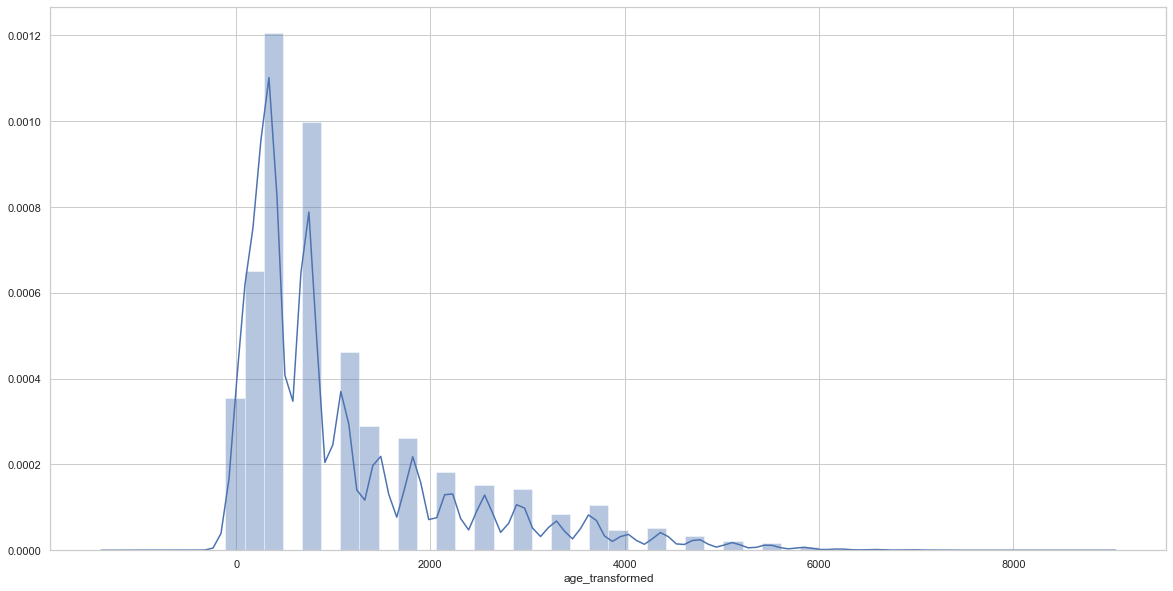

In [35]:
plt.figure(figsize = (20,10))
sns.distplot(dog_df.age_transformed)

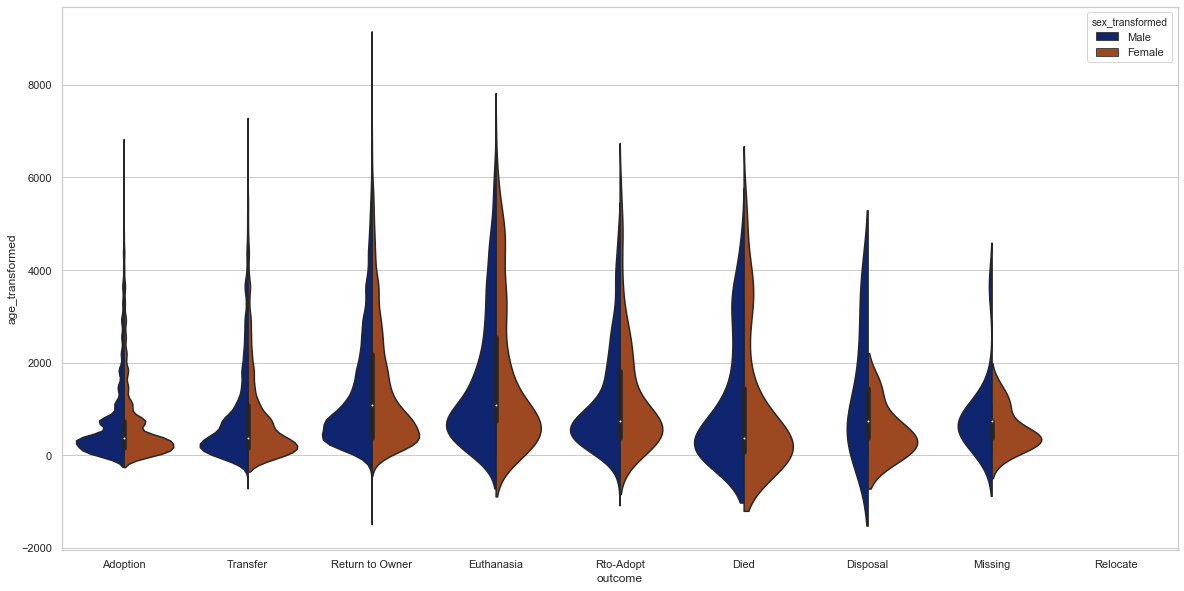

In [101]:
# dog age distribution: 
# adopted vs others
# 
plt.figure(figsize = (20,10))
sns.violinplot(x="outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".3",
               order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
               split=True)

In [78]:
dog_df['encode_outcome'] = dog_df.outcome.apply(lambda x: 'no_adopt' if x!= 'Adoption' else x)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


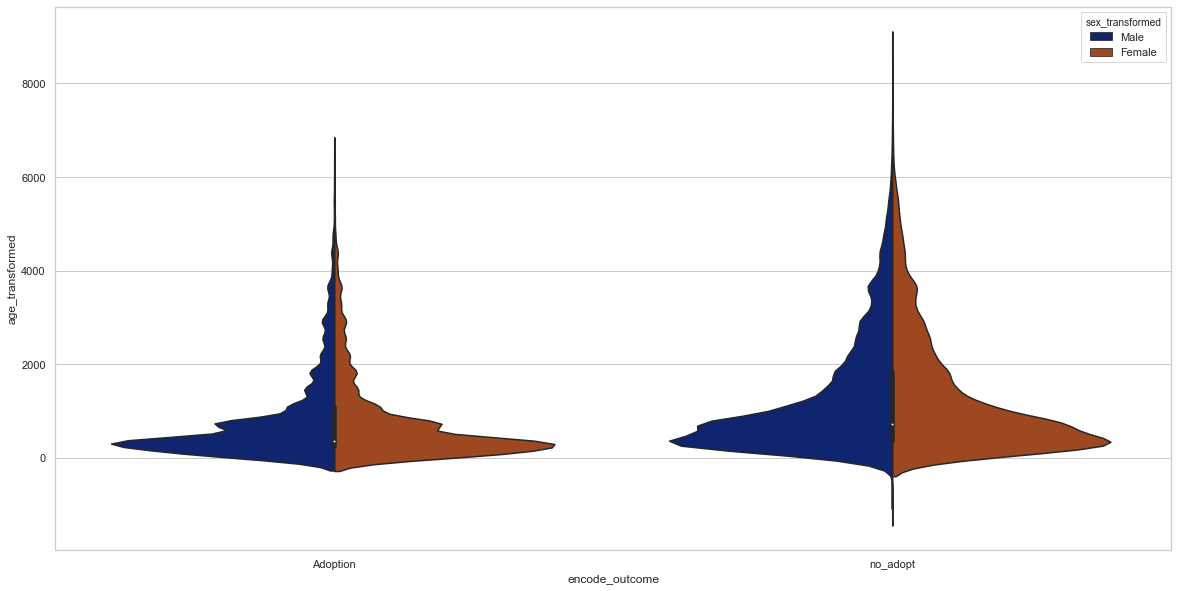

In [39]:
# visually, gender is not as big as a factor in adoption of dogs
# definitely more non-adopted dogs are older
plt.figure(figsize = (20,10))
sns.violinplot(x="encode_outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".6",
               split=True)

In [79]:
# average age of adopted versus not-adopted dogs

# male
adopted_male_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Male")].age_transformed
no_male_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Male")].age_transformed
# female
adopted_female_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Female")].age_transformed
no_female_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Female")].age_transformed

In [80]:
print("""
The average age of adopted male dogs is: {:.2f}
The average age of non-adopted male dogs is: {:.2f}
--
The average age of adopted female dogs is: {:.2f}
The average age of non-adopted female dogs is: {:.2f}
"""
      .format(adopted_male_dog.mean(), no_male_dog.mean(), 
              adopted_female_dog.mean(), no_female_dog.mean()))


The average age of adopted male dogs is: 725.57
The average age of non-adopted male dogs is: 1205.22
--
The average age of adopted female dogs is: 695.81
The average age of non-adopted female dogs is: 1195.45



In [81]:
tstat, p = stats.ttest_ind(adopted_male_dog, no_male_dog)
tstatf, pf = stats.ttest_ind(adopted_female_dog, no_female_dog)

In [82]:
print("""
(Comparison of the average age of adopted versus not-adopted male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of adopted versus not-adopted male dogs:
Result: -41.12 with the p-value of 0.00
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: -39.12 with the p-value of 0.00)



In [83]:
# age after 1700 days, seems like ratio started to change between adopt/ no-adopt
all_old = len(dog_df[dog_df.age_transformed > 1642])
adopted_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "Adoption")])
no_adopt_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "no_adopt")])

In [84]:
print("""
Percentage of dogs over 4.5 years old and
adopted: {:.2f}%,
not adopted: {:.2f}%
""".format(100*(adopted_old/all_old), 100*(no_adopt_old/all_old)))


Percentage of dogs over 4.5 years old and
adopted: 29.09%,
not adopted: 70.91%



In [ ]:
# write a funcion to guage the true limiting cutoff for age influencing adtoption

In [85]:
all_old = len(dog_df[dog_df.age_transformed > 2])
adopted_old = len(dog_df[(dog_df.age_transformed > 2) & (dog_df.encode_outcome == "Adoption")])
cal = adopted_old/all_old

In [119]:
age_at_adoption_d = []
adoption_rate_d = []
for age in range(1, (int(df.age_transformed.max()+1)), 365):
    all_old = len(dog_df[dog_df.age_transformed > age])
    adopted_old = len(dog_df[(dog_df.age_transformed > age) & (dog_df.encode_outcome == "Adoption")])
    cal = adopted_old/all_old
    age_at_adoption_d.append(int(age/365))
    adoption_rate_d.append(round(cal, 2))
    print("Age in year {} and relative adoption rate: {:.2f}%".format(age, cal*100))

    if cal <= 0:
        print("The time when adoption rate begin to go downhill...{:.2f}".format(age/365))
        break
    else:
        continue

Age in year 1 and relative adoption rate: 46.88%
Age in year 366 and relative adoption rate: 36.49%
Age in year 731 and relative adoption rate: 32.15%
Age in year 1096 and relative adoption rate: 30.39%
Age in year 1461 and relative adoption rate: 29.09%
Age in year 1826 and relative adoption rate: 27.30%
Age in year 2191 and relative adoption rate: 26.18%
Age in year 2556 and relative adoption rate: 25.28%
Age in year 2921 and relative adoption rate: 22.51%
Age in year 3286 and relative adoption rate: 20.34%
Age in year 3651 and relative adoption rate: 17.57%
Age in year 4016 and relative adoption rate: 16.09%
Age in year 4381 and relative adoption rate: 11.44%
Age in year 4746 and relative adoption rate: 8.64%
Age in year 5111 and relative adoption rate: 8.81%
Age in year 5476 and relative adoption rate: 5.95%
Age in year 5841 and relative adoption rate: 5.06%
Age in year 6206 and relative adoption rate: 5.00%
Age in year 6571 and relative adoption rate: 0.00%
The time when adoption 

Text(0.5, 1.0, 'Dogs are least likely to be adopted when they age?')

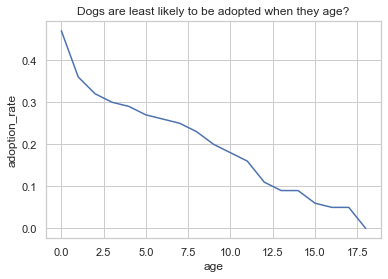

In [120]:
elbow_d = pd.DataFrame({'age': age_at_adoption_d, 'adoption_rate': adoption_rate_d})
sns.lineplot(x="age", y="adoption_rate", data=elbow_d)
plt.title("Dogs are least likely to be adopted when they age?")

In [113]:
cat_df['encode_outcome'] = cat_df.outcome.apply(lambda x: 'no_adopt' if x!= 'Adoption' else x)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


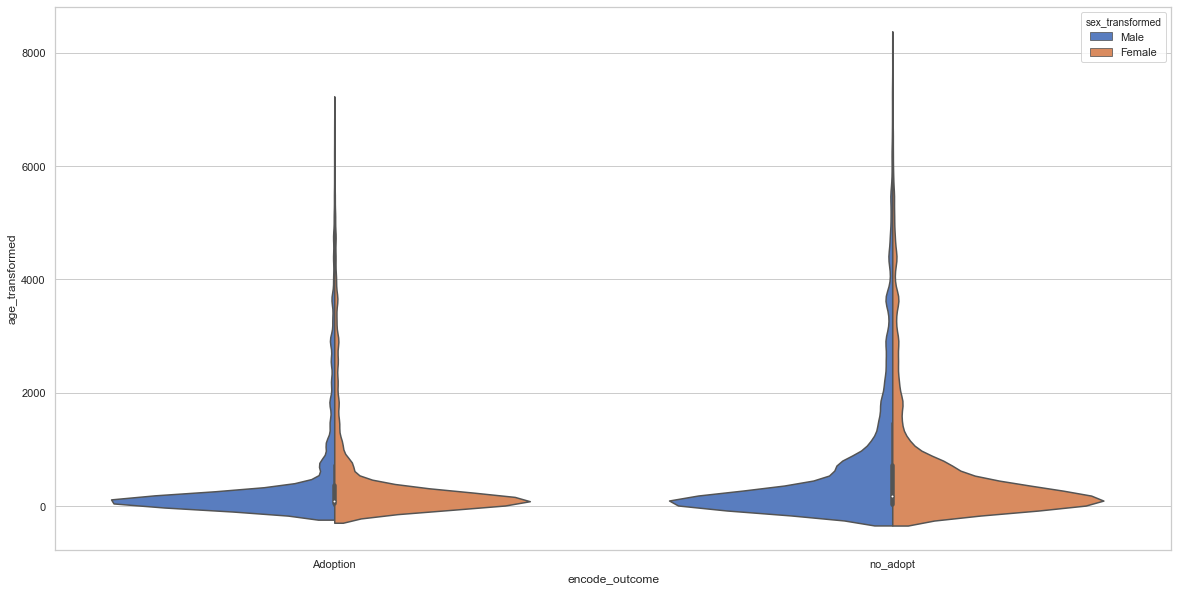

In [116]:
# older cats are less likely to be adopted
# but maybe not as obvious as dogs
plt.figure(figsize = (20,10))
sns.violinplot(x="encode_outcome", y="age_transformed", hue="sex_transformed",
               data=cat_df, palette="muted", edgecolor=".6",
               split=True, order = ['Adoption', 'no_adopt'])

In [115]:
# calculate how age of cats will become a limitimg factor for their adoption
# compared with dog adoptions, 
# older cats definitely seemed to have relative higher chance of getting adopted
age_at_adoption = []
adoption_rate = []
for age in range(1, (int(df.age_transformed.max()+1)), 365):
    all_old = len(cat_df[cat_df.age_transformed > age])
    adopted_old = len(cat_df[(cat_df.age_transformed > age) & (cat_df.encode_outcome == "Adoption")])
    cal = adopted_old/all_old
    age_at_adoption.append(int(age/365))
    adoption_rate.append(round(cal, 2))
    print("Age in year {} and relative adoption rate: {:.2f}%".format(age, cal*100))

    if cal <= 0:
        print("The time when adoption rate begin to go downhill...{:.2f}".format(age/365))
        break
    else:
        continue

Age in year 1 and relative adoption rate: 48.80%
Age in year 366 and relative adoption rate: 35.98%
Age in year 731 and relative adoption rate: 39.48%
Age in year 1096 and relative adoption rate: 39.92%
Age in year 1461 and relative adoption rate: 40.38%
Age in year 1826 and relative adoption rate: 41.15%
Age in year 2191 and relative adoption rate: 41.33%
Age in year 2556 and relative adoption rate: 40.34%
Age in year 2921 and relative adoption rate: 37.83%
Age in year 3286 and relative adoption rate: 36.06%
Age in year 3651 and relative adoption rate: 35.13%
Age in year 4016 and relative adoption rate: 31.38%
Age in year 4381 and relative adoption rate: 32.68%
Age in year 4746 and relative adoption rate: 26.92%
Age in year 5111 and relative adoption rate: 21.68%
Age in year 5476 and relative adoption rate: 19.01%
Age in year 5841 and relative adoption rate: 14.81%
Age in year 6206 and relative adoption rate: 10.64%
Age in year 6571 and relative adoption rate: 4.17%
Age in year 6936 a

Text(0.5, 1.0, 'Dogs are least likely to be adopted when they age?')

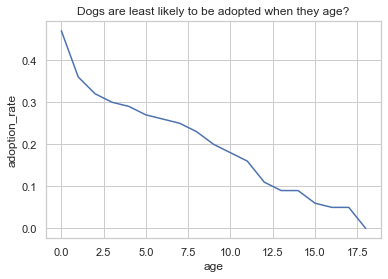

In [121]:
elbow_d = pd.DataFrame({'age': age_at_adoption_d, 'adoption_rate': adoption_rate_d})
sns.lineplot(x="age", y="adoption_rate", data=elbow_d)
plt.title("Dogs are least likely to be adopted when they age?")

Text(0.5, 1.0, 'Age of Cats may be not as big as a factor for adoption rate?')

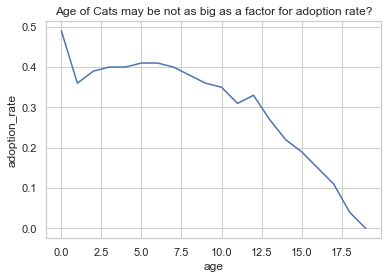

In [118]:
# and the trend of age-based decrease in adoptin rata 
# definitely much more obvious when visualized with lineplot
elbowc = pd.DataFrame({'age': age_at_adoption, 'adoption_rate': adoption_rate})
sns.lineplot(x="age", y="adoption_rate", data=elbowc)
plt.title('Age of Cats may be not as big as a factor for adoption rate?')

In [89]:
# handle names for whole dataframe
df['has_name'] = df[['name']]
df['has_name'] = df.has_name.fillna(value=0)
df['has_name'] = df.has_name.apply(lambda x: 1 if x != 0 else x)
df['has_name'] = df.has_name.astype('int64')

In [94]:
# next need to remove non word or digit in name column
# if there's any nan, need to convert to 0 as well

# has name makes a difference in animal outcome?

Text(0.5, 1, 'Is having a name important for animal adoption?')

<Figure size 1440x360 with 0 Axes>

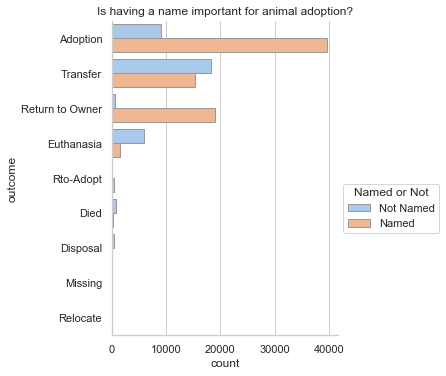

In [125]:
# peek the animal counts in different outcome
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="pastel", edgecolor=".6",
            data=df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title('Is having a name important for animal adoption?')

In [102]:
# handle names for dog dataframe
dog_df['has_name'] = dog_df[['name']]
dog_df['has_name'] = dog_df.has_name.fillna(value=0)
dog_df['has_name'] = dog_df.has_name.apply(lambda x: 1 if x != 0 else x)
dog_df['has_name'] = dog_df.has_name.astype('int64')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Text(0.5, 1, 'Is having a name important for dog adoption?')

<Figure size 1440x360 with 0 Axes>

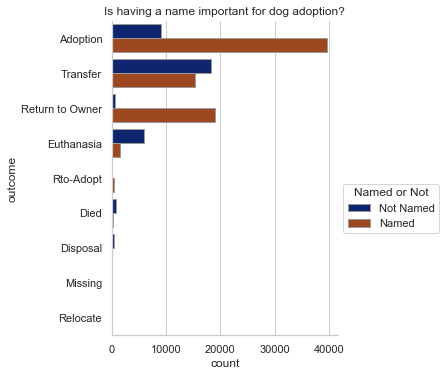

In [126]:
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="dark", edgecolor=".6",
            data=df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title("Is having a name important for dog adoption?")

In [122]:
# handle names for cat dataframe
cat_df['has_name'] = cat_df[['name']]
cat_df['has_name'] = cat_df.has_name.fillna(value=0)
cat_df['has_name'] = cat_df.has_name.apply(lambda x: 1 if x != 0 else x)
cat_df['has_name'] = cat_df.has_name.astype('int64')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Text(0.5, 1, 'Is having a name important for cat adoption?')

<Figure size 1440x360 with 0 Axes>

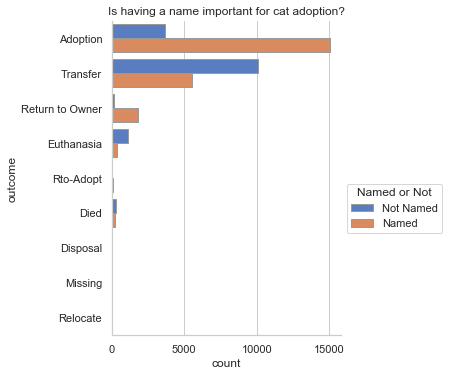

In [127]:
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", kind="count", hue = 'has_name',
            palette="muted", edgecolor=".6",
            data=cat_df, legend=False,
           order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'])
plt.legend(title='Named or Not', loc='upper left', labels=['Not Named', 'Named'], bbox_to_anchor=(1, 0.5))
plt.title("Is having a name important for cat adoption?")

## Explore breed & color

In [133]:
# handle color and breed
print(f"""
peek unique breed: 
{df.breed.nunique()}
-
peek unique colors:
{df.color.nunique()}
""")


peek unique breed: 
2504
-
peek unique colors:
580



In [134]:
import re

In [142]:
df.breed.str.contains('Mix').value_counts()

True     87514
False    24198
Name: breed, dtype: int64

In [140]:
# 78% contain the word mix
# True == 1
df.breed.str.contains('Mix').mean()

0.7833894299627614

In [154]:
df.breed.str.contains('/').mean()

0.09345459753652248

In [148]:
df.breed

0         Anatol Shepherd/Labrador Retriever
1                     Domestic Shorthair Mix
2                     Domestic Shorthair Mix
3                     Domestic Shorthair Mix
4                     Domestic Shorthair Mix
                         ...                
111748                Domestic Shorthair Mix
111749               Chihuahua Shorthair Mix
111750                Domestic Shorthair Mix
111751                   Norfolk Terrier Mix
111752                Domestic Shorthair Mix
Name: breed, Length: 111712, dtype: object

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111712 entries, 0 to 111752
Data columns (total 12 columns):
date_time          111712 non-null object
name               76503 non-null object
outcome            111712 non-null object
species            111712 non-null object
sex                111712 non-null object
sex_transformed    111712 non-null object
breed              111712 non-null object
color              111712 non-null object
age_destiny        111712 non-null object
age_transformed    111712 non-null float64
has_name           111712 non-null int64
breed_type         111712 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 16.1+ MB


In [171]:
df['breed_type'] = df.breed.str.extract(r'({})'.format('|'.join(['Mix'])), 
                        flags=re.IGNORECASE, expand=False).str.lower().fillna('pure')

In [172]:
df.breed_type.value_counts()

mix     87514
pure    24198
Name: breed_type, dtype: int64

In [145]:
df.breed.value_counts()

Domestic Shorthair Mix                   30467
Pit Bull Mix                              8134
Labrador Retriever Mix                    6418
Chihuahua Shorthair Mix                   6064
Domestic Shorthair                        3977
                                         ...  
Bruss Griffon/Affenpinscher                  1
Catahoula/Black Mouth Cur                    1
Pit Bull/Anatol Shepherd                     1
English Springer Spaniel/Beagle              1
Australian Shepherd/Queensland Heeler        1
Name: breed, Length: 2504, dtype: int64

In [185]:
# contain forward slash also mix...> count as relative pure?
df.loc[df.breed.str.contains("/") == True, "breed_type", regex=False] = "mix"

SyntaxError: invalid syntax (<ipython-input-185-ff70ff2ad5eb>, line 2)

In [188]:
df["breed_type"] = np.where((df.breed.str.contains("/")|df.breed.str.contains("Mix")), "mix", df.breed_type)
   

array(['mix', 'mix', 'mix', ..., 'mix', 'mix', 'mix'], dtype=object)

In [ ]:
cat_temp = df[df.species == 'Cat']
cat_temp.color.nunique()

In [ ]:
dog_temp = df[df.species == 'Dog']
dog_temp.color.nunique()

In [ ]:
import re

In [ ]:
# take care of months
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'months' in x else x)
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'month' in x else x)

In [128]:
def name_adopt_relationship(data):
    # get unique names
    name_list = data.Name.dropna().unique()
    # convert ndarray to list for iteration
    name_list = list(name_list)
    # create empty lists to hold calculated data
    name = []
    adopt_rate = []
    count = []
    dict = {}
    for n in name_list:
        # store name into list
        name.append(n)
        # calculate adoption rate for each name 
        # divide by all outcomes attached with that particular name
        rate = len(data[(data.Name == n) & (data["Outcome Type"] == "Adoption")]) / len(data[data.Name == n])
        # store name into rate
        adopt_rate.append(rate)
        count.append(len(data[data.Name == n]))
    dict = {'pet_name': name, 'name_count': count, 'adopt_rate': adopt_rate}
    return pd.DataFrame(dict)

In [ ]:
cat = name_adopt_relationship(cat)
cat

In [ ]:
cat[cat.name_count >= 50].sort_values(by = 'adopt_rate', ascending = False)

In [129]:
dog_result = name_adopt_relationship(dog)
dog_result

KeyboardInterrupt: 

In [ ]:
dog_result[dog_result.name_count >= 30].sort_values(by = 'adopt_rate', ascending = False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [ ]:
df[df.Name == 'Sasha']["Outcome Type"].value_counts()

In [ ]:
df[df.Name == 'Rocky']["Outcome Type"].value_counts()

In [ ]:
len(df[(df.Name == 'Rocky') & (df["Outcome Type"] == "Adoption")]) / len(df[df.Name == 'Rocky'])

In [ ]:
df.groupby('Name')['Outcome Type'].nunique().sort_values(ascending=False)

In [ ]:
df_19[df_19.DateTime == df_19.MonthYear].info()

In [ ]:
df_19['Animal Type'].value_counts()

In [ ]:
df_19.info()

In [ ]:
prepare.report_col_with_null(df_19)

Using real data from Animal Care Services and a Decision Tree Classifier, I was able to predict if an animal would be euthanized or adopted with an accuracy of over 90%. To achieve this result I engineered new features by thinking about what factors contribute to an animal being adopted and also used undersampling to balance the classes. I then used cross-validation and tried several classification models to determine which performed the best.

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.info()

In [ ]:
df.AnimalType.unique()

In [ ]:
# ID seems unique
df.AnimalID.nunique()

In [ ]:
df.head()

In [ ]:
df.OutcomeType.value_counts().plot(kind='bar')

**Initial thought after peek at data**
1. sep animal type
2. animals w/o names might have worse outcome
3. more adoption: neutered/ spayed ones, young, specific breed/ color

A lot of encoding?

In [ ]:
# missing a lot of names
# animals without names > worse outcome?
df.Name.isnull().sum()

In [ ]:
# this works too lol
check = df.columns[df.isnull().any()]
check

In [ ]:
null_pd = prepare.report_col_with_null(df)

In [ ]:
null_pd

In [ ]:
pd.crosstab(df.AnimalType, df.OutcomeType).apply(lambda r: r/r.sum(), axis=1)

In [ ]:
pd.crosstab(df.OutcomeType, df.AnimalType).apply(lambda r: r/r.sum(), axis=1)

In [ ]:
df.replace(r'^\s*$', np.nan, regex = True, inplace = True) 

In [ ]:
(df.DateTime.value_counts(sort = False)).plot()